In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import seaborn as sns


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
data = pd.read_csv('/content/Online Retail.csv')
data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
62546,541506,85231b,CINAMMON SET OF 9 T-LIGHTS,1,1/18/2011 16:05,1.63,NaN,United Kingdom
62547,541506,DOT,DOTCOM POSTAGE,1,1/18/2011 16:05,118.33,NaN,United Kingdom
62548,541507,22719,GUMBALL MONOCHROME COAT RACK,1,1/18/2011 16:05,2.46,NaN,United Kingdom
62549,541507,22807,SET OF 6 T-LIGHTS TOADSTOOLS,1,1/18/2011 16:05,5.79,NaN,United Kingdom


### **Preprocessing:**

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62551 entries, 0 to 62550
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   InvoiceNo    62551 non-null  object 
 1   StockCode    62551 non-null  object 
 2   Description  62388 non-null  object 
 3   Quantity     62551 non-null  int64  
 4   InvoiceDate  62551 non-null  object 
 5   UnitPrice    62550 non-null  float64
 6   CustomerID   38501 non-null  float64
 7   Country      62550 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 3.8+ MB


In [ ]:
data.describe()

,Quantity,UnitPrice,CustomerID
count,62551.000000,62550.000000,38501.000000
mean,8.352017,5.917764,15387.412379
std,423.334622,149.005085,1765.391847
min,-74215.000000,0.000000,12346.000000
25%,1.000000,1.250000,13984.000000
50%,2.000000,2.510000,15358.000000
75%,8.000000,4.250000,17017.000000
max,74215.000000,16888.020000,18283.000000


In [ ]:
data.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

In [ ]:
data.dtypes.value_counts()

object     5
float64    2
int64      1
Name: count, dtype: int64

In [ ]:
data.shape

(62551, 8)

In [ ]:
data.isnull().sum()

InvoiceNo          0
StockCode          0
Description      163
Quantity           0
InvoiceDate        0
UnitPrice          1
CustomerID     24050
Country            1
dtype: int64

In [ ]:
data=data.drop_duplicates()
data.duplicated().sum()

0

In [ ]:
data = data.dropna(subset=['CustomerID'])

In [ ]:
data.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [ ]:
# Data cleaning
data["Quantity"].unique()
data= data[data['Quantity'] > 0]
data['TotalPrice'] = data['Quantity'] * data['UnitPrice']

In [ ]:
# Convert 'InvoiceDate' to datetime
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

### **Feature** **Engineering**:


This groups the data by 'CustomerID' and aggregates it to create features such as total spending ('TotalPrice'), order frequency ('InvoiceNo'), the date of the last purchase ('InvoiceDate'), and total quantity of items purchased ('Quantity').

In [ ]:
# Aggregate data at the customer level
customer_data = data.groupby('CustomerID').agg({
    'TotalPrice': 'sum',
    'InvoiceNo': 'nunique',
    'InvoiceDate': 'max',
    'Quantity': 'sum'
}).reset_index()

#Rename columns:
customer_data.columns = ['CustomerID', 'TotalSpending', 'OrderFrequency', 'LastPurchaseDate', 'TotalQuantity']
customer_data['LastPurchaseDate'] = pd.to_datetime(customer_data['LastPurchaseDate'])


In [ ]:
# Calculate Recency
# Compute the maximum date from the data
reference_date = data['InvoiceDate'].max()

# Ensure that 'LastPurchaseDate' is a datetime object and perform the calculation
if pd.api.types.is_datetime64_any_dtype(customer_data['LastPurchaseDate']):
    customer_data['Recency'] = (reference_date - customer_data['LastPurchaseDate']).dt.days
else:
    raise TypeError("LastPurchaseDate is not of datetime type.")


In [ ]:
# Normalize/Standardize features
features = customer_data[['TotalSpending', 'OrderFrequency', 'Recency', 'TotalQuantity']]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

### **Dimensionality Reduction with** **PCA**

In [ ]:
#  Dimensionality Reduction with PCA
pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)

### **Determining Optimal Number of** **Clusters**

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

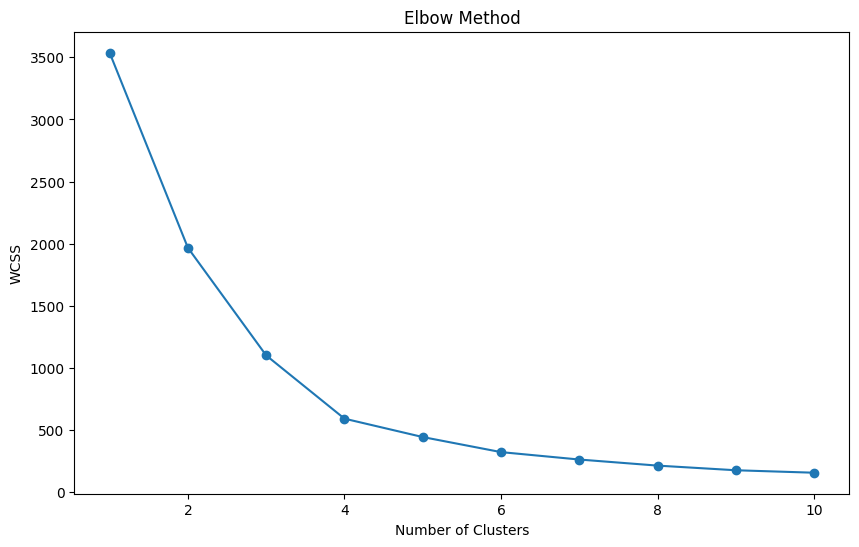

In [ ]:

#  Determining Optimal Number of Clusters
# Elbow Method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(pca_features)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

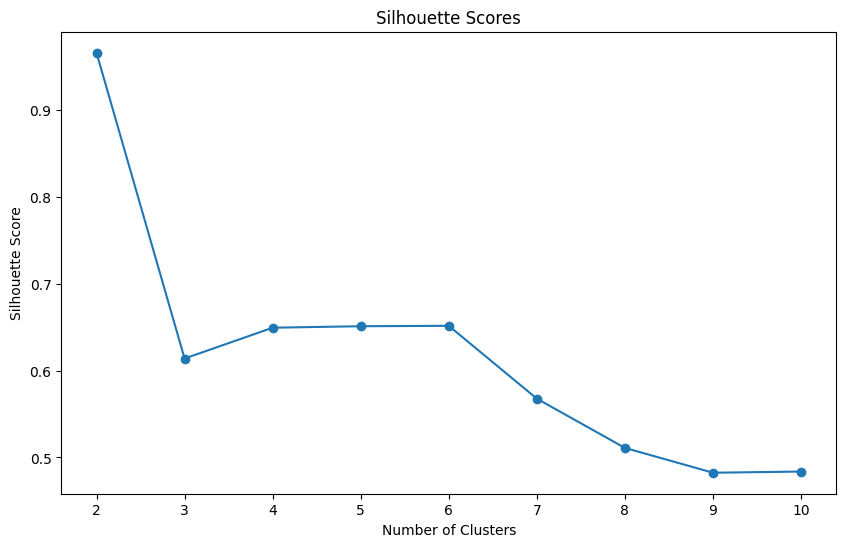

In [ ]:
# Silhouette Analysis
silhouette_scores = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(pca_features)
    silhouette_scores.append(silhouette_score(pca_features, kmeans.labels_))

plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Silhouette Scores')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

### **K-means Clustering**



In [ ]:
# Step 5: K-means Clustering
# From the above analysis, choose the optimal number of clusters (let's assume it's 4)
optimal_clusters = 4
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
customer_data['Cluster'] = kmeans.fit_predict(pca_features)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


### **Cluster Profiling**

In [ ]:

cluster_profiles = customer_data.groupby('Cluster').agg({
    'TotalSpending': 'mean',
    'OrderFrequency': 'mean',
    'Recency': 'mean',
    'TotalQuantity': 'mean'
}).reset_index()

print(cluster_profiles)

   Cluster  TotalSpending  OrderFrequency    Recency  TotalQuantity
0        0   12055.440556       11.000000   8.722222    6214.222222
1        1     397.806499        1.215071  38.681319     235.003140
2        2   77183.600000        1.000000   0.000000   74215.000000
3        3     869.057341        2.105495   8.736264     464.487912


### **Visualization**


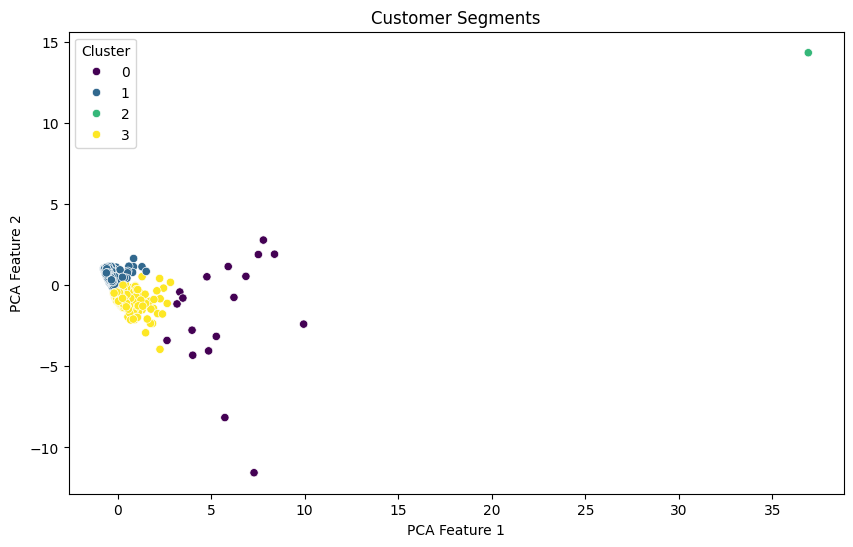

In [ ]:

plt.figure(figsize=(10, 6))
sns.scatterplot(x=pca_features[:, 0], y=pca_features[:, 1], hue=customer_data['Cluster'], palette='viridis')
plt.title('Customer Segments')
plt.xlabel('PCA Feature 1')
plt.ylabel('PCA Feature 2')
plt.legend(title='Cluster')
plt.show()

### **Evaluation**

In [ ]:

silhouette_avg = silhouette_score(pca_features, customer_data['Cluster'])
print(f'Silhouette Score: {silhouette_avg}')

Silhouette Score: 0.6494178999079003


In [ ]:
# Personalization and Recommendations
# Tailor strategies based on cluster profiles
for i in range(optimal_clusters):
    print(f'Cluster {i} Recommendations:')
    print(f'Average Spending: {cluster_profiles.iloc[i]["TotalSpending"]}')
    print(f'Order Frequency: {cluster_profiles.iloc[i]["OrderFrequency"]}')
    print(f'Recency: {cluster_profiles.iloc[i]["Recency"]}')
    print(f'Total Quantity: {cluster_profiles.iloc[i]["TotalQuantity"]}')
    print()

Cluster 0 Recommendations:
Average Spending: 12055.440555555555
Order Frequency: 11.0
Recency: 8.722222222222221
Total Quantity: 6214.222222222223

Cluster 1 Recommendations:
Average Spending: 397.80649921507063
Order Frequency: 1.2150706436420722
Recency: 38.68131868131868
Total Quantity: 235.00313971742543

Cluster 2 Recommendations:
Average Spending: 77183.6
Order Frequency: 1.0
Recency: 0.0
Total Quantity: 74215.0

Cluster 3 Recommendations:
Average Spending: 869.0573406593408
Order Frequency: 2.1054945054945056
Recency: 8.736263736263735
Total Quantity: 464.4879120879121

